In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import wandb
import pandas as pd


## Waymo Test 3D

In [28]:
def remove_trash_in_keys(pd):
    for k in pd.keys():
        if '_202' in k:
            split = k.split('_202')
            new_k = split[0] + ' - ' + split[1].split(' - ')[-1]
            # print(new_k)
            pd = pd.rename(columns = {k:new_k})
    return pd

def create_plot_for_waymo_results(test_path='kitti_test_moderate.csv', 
                              vis_path=None, 
                              difficulty='moderate', 
                              num_trials = 3,
                              PC_type = '3D'):
    
    
    our_method_name = 'greedyboxbadge_filter541'
    
    methods = ['random',  'entropy', 'montecarlo','llal','coreset','badge', our_method_name]

    kitti_test = pd.read_csv(test_path)
    
    indices = [0]
    for i in range(1, len(kitti_test.columns)):
        if (i-1) % num_trials == 0:
            indices.append(i)

    kitti_test = kitti_test.iloc[:, indices]
    kitti_test = kitti_test.loc[:, ~kitti_test.columns.duplicated()]

    m_ap = []
    strategies = []
    num_point_clouds = []
    num_point_clouds_count = 0
    percentage_point_clouds=[]

    for method in methods:
            trials_name = ['Step',
                           'waymo_dataset_pv_rcnn_active_' + method + '_40_40_400_400 - Average/APH_Level_2']
        num_point_clouds_count = 0
        for index, row in kitti_test.iterrows():
            if row['Step'] % 40 == 0:
                num_point_clouds_count += 100
                for trial in range(num_trials):
                    trial = trial + 1
                    m_ap.append(row[trials_name[trial]])
                    
                    num_point_clouds.append(num_point_clouds_count)
                    percentage_point_clouds.append(num_point_clouds_count/3712)
                    strategies.append(method)
    
    strategies = list(map(lambda x: x.replace('greedyboxbadge', 'ours'), strategies))
    
    # Vis mode, we only need to change x axix, from percentage_point_clouds to percentage_boxes. 
    num_bounding_boxes = []
    if vis_path is not None:
        kitti_vis = pd.read_csv(vis_path, index_col=False)
        indices = [0]
        for i in range(1, len(kitti_vis.columns)):
            if (i-1) % num_trials == 0:
                indices.append(i)

        kitti_vis = kitti_vis.iloc[:, indices]
        kitti_vis = kitti_vis.loc[:, ~kitti_vis.columns.duplicated()]
        
        
        for method in methods:
            waymo_dataset_pv_rcnn_active_greedyboxbadge_filter541_40_40_400_400 - Average/APH_Level_2
            trials_name = ['Step',
                   'waymo_dataset_pv_rcnn_active_' + method + '_40_40_400_400 - Average/APH_Level_2']
            
            no_null_data=[]
            for i in range(num_trials):
                no_null_data.append(kitti_vis[[trials_name[0],trials_name[i+1]]].dropna().reset_index(drop=True))
            
            step_indices = [i*2 for i in range(num_trials)]
            means = pd.concat(no_null_data, axis=1, ignore_index=True)[step_indices].mean(axis=1)
            for mean in means:
                for i in range(num_trials):
                    num_bounding_boxes.append(mean)
                    

    d = {"Percentage(%) of Selected Point Clouds": num_point_clouds, PC_type+'APH_Level_2 - '+difficulty.capitalize(): m_ap, 'AL method': strategies}

    if vis_path is not None:
        d = {"Number of Selected Bounding Boxes": num_bounding_boxes, 
             'APH_Level_2 - '+difficulty.capitalize(): m_ap, 'AL method': strategies}
        
    data = pd.DataFrame(data=d)
    
    
    """Plot Code"""
    
    sns.set(font_scale=2) 
    sns.set_context(rc={"lines.linewidth": 3, 
                        'xtick.labelsize': 26,
                        'ytick.labelsize': 26,
                        'legend.fontsize': 24,
                        'axes.labelsize': 26
    })
    
    sns.set_style("white")
    fig = plt.figure(figsize=[12,8])
    ax = plt.axes()
    
    if vis_path is None:
        g=sns.lineplot(
            data=data,
            x="Percentage(%) of Selected Point Clouds", y=PC_type+" mAP(%) - "+difficulty.capitalize(),
            markers=True, dashes=False, hue="AL method", style="AL method", markersize=15, err_style='bars', alpha=1
            # err_kws={'alpha':0.1}
        )
        xsticks_list = [100,200,300,400,500,600]
        g.set_xticks([100,200,300,400,500,600]) 
        xsticks_list = ["{:.1f}".format((stick*100/3712)) for stick in xsticks_list]
        g.set_xticklabels(xsticks_list)

    else:
        g=sns.lineplot(
            data=data,
            x="Number of Selected Bounding Boxes", y=PC_type+' mAP(%) - '+difficulty.capitalize(),
            markers=True, dashes=False, hue="AL method", style="AL method", markersize=15, err_style='band', alpha=1,
            err_kws={'alpha':0.15}
        )
    g.legend_.set_title(None)
        
    plt.setp(ax.get_legend().get_texts(), fontsize='26')
    for t, l in zip(g.legend().get_texts(), g.legend().get_lines()):
        # l.set_marker('o')
        l.set_markersize(15)
    
    
    # ax.set_xlim(234,3501)
    # ax.set_title('Comparison among different values of bandwith')
    save_type = 'pc' if vis_path is None else 'box'
    plt.savefig("output/kitti_"+PC_type+"_"+difficulty+"_"+save_type+"_level.pdf", format="pdf", bbox_inches="tight")

# create_plot_for_kitt_test(test_path='kitti_test_3d_moderate.csv', 
#                           vis_path='kitti_vis_3d_moderate.csv', 
#                           difficulty='moderate')
# create_plot_for_kitt_test(test_path='kitti_test_3d_hard.csv', 
#                           vis_path='kitti_vis_3d_hard.csv', 
#                           difficulty='hard')
# create_plot_for_kitt_test(test_path='kitti_test_3d_hard.csv', 
#                           difficulty='hard')
# create_plot_for_kitt_test(test_path='kitti_test_3d_moderate.csv', 
#                           difficulty='moderate')

# create_plot_for_kitt_test(test_path='kitti_test_3d_ez.csv',
#                           difficulty='easy')
# create_plot_for_kitt_test(test_path='kitti_test_3d_ez.csv',
#                           vis_path='kitti_vis_3d_ez.csv', 
#                           difficulty='easy')

# create_plot_for_kitt_test(test_path='kitti_test_3d_ez.csv',
#                           difficulty='easy')

# create_plot_for_kitt_test(test_path='kitti_test_BEV_ez.csv',
#                           difficulty='easy',
#                           PC_type='BEV')

# create_plot_for_kitt_test(test_path='kitti_test_BEV_moderate.csv',
#                           difficulty='moderate',
#                           PC_type='BEV')


# create_plot_for_kitt_test(test_path='kitti_test_BEV_hard.csv',
#                           difficulty='hard',
#                           PC_type='BEV')


create_plot_for_waymo_results(test_path='kitti_test_BEV_hard.csv',
                          vis_path='kitti_vis_BEV_hard.csv',
                          difficulty='hard',
                          PC_type='BEV')

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 30)

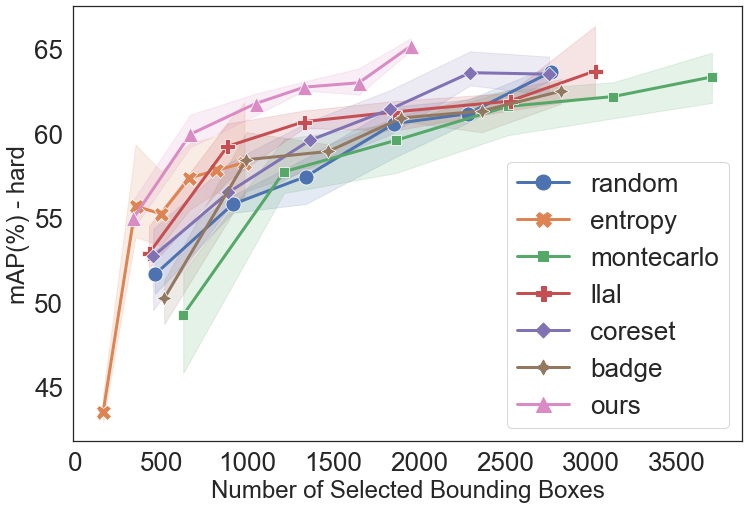

In [ ]:
create_plot_for_kitt_test(test_path='kitti_test_3d_hard.csv', 
                          vis_path='kitti_vis_3d_hard.csv', 
                          difficulty='hard')

## Waymo Vis

In [7]:
def remove_trash_in_keys(pd):
    for k in pd.keys():
        if '_202' in k:
            split = k.split('_202')
            new_k = split[0] + ' - ' + split[1].split(' - ')[-1]
            # print(new_k)
            pd = pd.rename(columns = {k:new_k})
    return pd

def create_plot_for_waymo_results(test_path=None, 
                              vis_path=None, 
                              difficulty='moderate', 
                              num_trials = 3,
                              PC_type = '3D'):
    
    
    our_method_name = 'greedyboxbadge_filter541'
    
    methods = ['random',  'entropy', 'montecarlo','llal','coreset','badge', our_method_name]

    waymo_vis = pd.read_csv(vis_path)
    
    indices = [0]
    for i in range(1, len(waymo_vis.columns)):
        if (i-1) % num_trials == 0:
            indices.append(i)

    waymo_vis = waymo_vis.iloc[:, indices]
    waymo_vis = waymo_vis.loc[:, ~waymo_vis.columns.duplicated()]
    
    print(waymo_vis)
    
    m_ap = []
    strategies = []
    num_point_clouds = []
    num_point_clouds_count = 0
    percentage_point_clouds=[]

    for method in methods:
        trials_name = ['Step', 'waymo_dataset_pv_rcnn_active_' + method + '_40_40_400_400 - Average/APH_Level_2']
        num_point_clouds_count = 0
        for index, row in kitti_test.iterrows():
            if row['Step'] % 40 == 0:
                num_point_clouds_count += 100
                for trial in range(num_trials):
                    trial = trial + 1
                    m_ap.append(row[trials_name[trial]])
                    
                    num_point_clouds.append(num_point_clouds_count)
                    percentage_point_clouds.append(num_point_clouds_count/3712)
                    strategies.append(method)
    
    strategies = list(map(lambda x: x.replace('greedyboxbadge', 'ours'), strategies))
    
    # Vis mode, we only need to change x axix, from percentage_point_clouds to percentage_boxes. 
    num_bounding_boxes = []
    if vis_path is not None:
        kitti_vis = pd.read_csv(vis_path, index_col=False)
        indices = [0]
        for i in range(1, len(kitti_vis.columns)):
            if (i-1) % num_trials == 0:
                indices.append(i)

        kitti_vis = kitti_vis.iloc[:, indices]
        kitti_vis = kitti_vis.loc[:, ~kitti_vis.columns.duplicated()]
        
        
        for method in methods:
            waymo_dataset_pv_rcnn_active_greedyboxbadge_filter541_40_40_400_400 - Average/APH_Level_2
            trials_name = ['Step',
                   'waymo_dataset_pv_rcnn_active_' + method + '_40_40_400_400 - Average/APH_Level_2']
            
            no_null_data=[]
            for i in range(num_trials):
                no_null_data.append(kitti_vis[[trials_name[0],trials_name[i+1]]].dropna().reset_index(drop=True))
            
            step_indices = [i*2 for i in range(num_trials)]
            means = pd.concat(no_null_data, axis=1, ignore_index=True)[step_indices].mean(axis=1)
            for mean in means:
                for i in range(num_trials):
                    num_bounding_boxes.append(mean)
                    

    d = {"Percentage(%) of Selected Point Clouds": num_point_clouds, PC_type+'APH_Level_2 - '+difficulty.capitalize(): m_ap, 'AL method': strategies}

    if vis_path is not None:
        d = {"Number of Selected Bounding Boxes": num_bounding_boxes, 
             'APH_Level_2 - '+difficulty.capitalize(): m_ap, 'AL method': strategies}
        
    data = pd.DataFrame(data=d)
    
    
    """Plot Code"""
    
    sns.set(font_scale=2) 
    sns.set_context(rc={"lines.linewidth": 3, 
                        'xtick.labelsize': 26,
                        'ytick.labelsize': 26,
                        'legend.fontsize': 24,
                        'axes.labelsize': 26
    })
    
    sns.set_style("white")
    fig = plt.figure(figsize=[12,8])
    ax = plt.axes()
    
    if vis_path is None:
        g=sns.lineplot(
            data=data,
            x="Percentage(%) of Selected Point Clouds", y=PC_type+" mAP(%) - "+difficulty.capitalize(),
            markers=True, dashes=False, hue="AL method", style="AL method", markersize=15, err_style='bars', alpha=1
            # err_kws={'alpha':0.1}
        )
        xsticks_list = [100,200,300,400,500,600]
        g.set_xticks([100,200,300,400,500,600]) 
        xsticks_list = ["{:.1f}".format((stick*100/3712)) for stick in xsticks_list]
        g.set_xticklabels(xsticks_list)

    else:
        g=sns.lineplot(
            data=data,
            x="Number of Selected Bounding Boxes", y=PC_type+' mAP(%) - '+difficulty.capitalize(),
            markers=True, dashes=False, hue="AL method", style="AL method", markersize=15, err_style='band', alpha=1,
            err_kws={'alpha':0.15}
        )
    g.legend_.set_title(None)
        
    plt.setp(ax.get_legend().get_texts(), fontsize='26')
    for t, l in zip(g.legend().get_texts(), g.legend().get_lines()):
        # l.set_marker('o')
        l.set_markersize(15)
    
    
    # ax.set_xlim(234,3501)
    # ax.set_title('Comparison among different values of bandwith')
    save_type = 'pc' if vis_path is None else 'box'
    plt.savefig("output/kitti_"+PC_type+"_"+difficulty+"_"+save_type+"_level.pdf", format="pdf", bbox_inches="tight")

# create_plot_for_kitt_test(test_path='kitti_test_3d_moderate.csv', 
#                           vis_path='kitti_vis_3d_moderate.csv', 
#                           difficulty='moderate')
# create_plot_for_kitt_test(test_path='kitti_test_3d_hard.csv', 
#                           vis_path='kitti_vis_3d_hard.csv', 
#                           difficulty='hard')
# create_plot_for_kitt_test(test_path='kitti_test_3d_hard.csv', 
#                           difficulty='hard')
# create_plot_for_kitt_test(test_path='kitti_test_3d_moderate.csv', 
#                           difficulty='moderate')

# create_plot_for_kitt_test(test_path='kitti_test_3d_ez.csv',
#                           difficulty='easy')
# create_plot_for_kitt_test(test_path='kitti_test_3d_ez.csv',
#                           vis_path='kitti_vis_3d_ez.csv', 
#                           difficulty='easy')

# create_plot_for_kitt_test(test_path='kitti_test_3d_ez.csv',
#                           difficulty='easy')

# create_plot_for_kitt_test(test_path='kitti_test_BEV_ez.csv',
#                           difficulty='easy',
#                           PC_type='BEV')

# create_plot_for_kitt_test(test_path='kitti_test_BEV_moderate.csv',
#                           difficulty='moderate',
#                           PC_type='BEV')


# create_plot_for_kitt_test(test_path='kitti_test_BEV_hard.csv',
#                           difficulty='hard',
#                           PC_type='BEV')


create_plot_for_waymo_results(test_path='kitti_test_BEV_hard.csv',
                          vis_path='kitti_vis_BEV_hard.csv',
                          difficulty='hard',
                          PC_type='BEV')

     Step  \
0     161   
1     284   
2     304   
3     323   
4     327   
..    ...   
99   3240   
100  3613   
101  3697   
102  3700   
103  3794   

     kitti_dataset_pv_rcnn_active_greedyboxbadge_2_40_40_100_100 - Average/bev_hard_R40  \
0                                                  NaN                                    
1                                                  NaN                                    
2                                                  NaN                                    
3                                                  NaN                                    
4                                                  NaN                                    
..                                                 ...                                    
99                                                 NaN                                    
100                                                NaN                                    
101                     

NameError: name 'kitti_test' is not defined

## Final WAYMO VIS Plot

8053.0 Step                                                                                  8053.000000
waymo_dataset_pv_rcnn_active_NTK_maxdet_linear_40_40_400_400 - Average/APH_Level_2       0.309533
Name: 1, dtype: float64
13304.0 Step                                                                                  13304.00000
waymo_dataset_pv_rcnn_active_NTK_maxdet_linear_40_40_400_400 - Average/APH_Level_2        0.33885
Name: 4, dtype: float64
17423.0 Step                                                                                  17423.000000
waymo_dataset_pv_rcnn_active_NTK_maxdet_linear_40_40_400_400 - Average/APH_Level_2        0.328765
Name: 7, dtype: float64
22581.0 Step                                                                                  22581.000000
waymo_dataset_pv_rcnn_active_NTK_maxdet_linear_40_40_400_400 - Average/APH_Level_2        0.346423
Name: 10, dtype: float64
28805.0 Step                                                                        

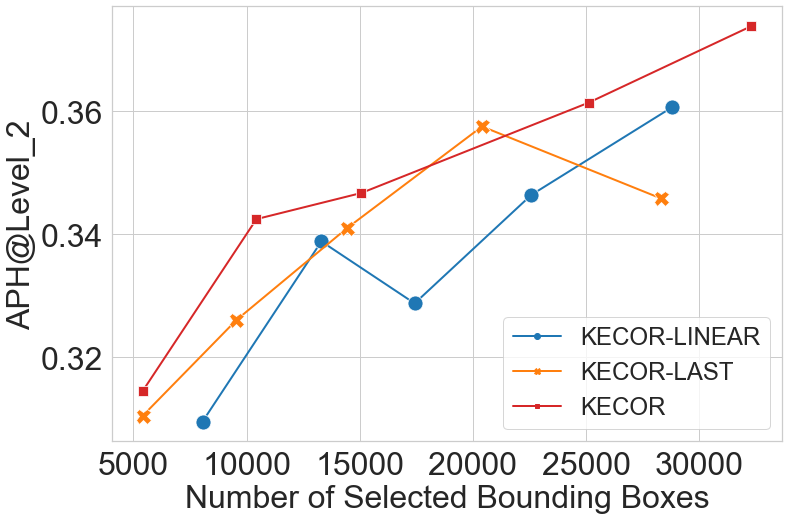

In [36]:

def remove_trash_in_keys(pd):
    for k in pd.keys():
        if '_202' in k:
            split = k.split('_202')
            new_k = split[0] + ' - ' + split[1].split(' - ')[-1]
            # print(new_k)
            pd = pd.rename(columns = {k:new_k})
    return pd


vis_path = "iccv2023_waymo/aph_level2_vis.csv"
vis_baseline_path = "iccv2023_waymo/aph_level_2_abl.csv"

waymo_vis = pd.read_csv(vis_path)
waymo_vis = remove_trash_in_keys(waymo_vis)
waymo_vis_baseline = pd.read_csv(vis_baseline_path)
waymo_vis_baseline = remove_trash_in_keys(waymo_vis_baseline)

baseline_methods = ['NTK_maxdet_linear', 'NTK_maxdet_ll']
# methods = ['NTK_maxdet_grad_new_ent05']
# baseline_methods = [ 'random', 'entropy', 'mc', 'coreset', 'badge',  'llal', 'greedyboxbadge_1']
PC_type = '3D'

metric = 'APH_Level_2'
metric_name = 'APH@Level_2'

# print(waymo_vis[trials_name[-1]])

d = {'Number of Selected Bounding Boxes': [], 
     metric: [], 'AL method': [], metric_name:[]}

for method in baseline_methods:
    trials_name = ['Step', 'waymo_dataset_pv_rcnn_active_' + method + '_40_40_400_400 - Average/' + metric]
    for index, row in waymo_vis_baseline.iterrows():
        if not pd.isna(row[trials_name][1]):
            print(row[0], row[trials_name])
            d['Number of Selected Bounding Boxes'].append(row[0])
            d[metric_name].append(row[trials_name][1])
            d[metric].append(row[trials_name][1])
            d['AL method'].append(method)
            
for method in methods:
    trials_name = ['Step', 'waymo_dataset_pv_rcnn_active_' + method + '_40_40_400_400 - Average/' + metric]
    for index, row in waymo_vis.iterrows():
        if not pd.isna(row[trials_name][1]):
            print(row[0], row[trials_name])
            d['Number of Selected Bounding Boxes'].append(row[0])
            d[metric_name].append(row[trials_name][1])
            d[metric].append(row[trials_name][1])
            d['AL method'].append(method)




d['AL method'] = list(map(lambda x: x.replace('NTK_maxdet_grad_new_ent05', 'KECOR'), d['AL method']))
d['AL method'] = list(map(lambda x: x.replace('NTK_maxdet_linear', 'KECOR-linear'), d['AL method']))
d['AL method'] = list(map(lambda x: x.replace('NTK_maxdet_ll', 'KECOR-last'), d['AL method']))
d['AL method'] = list(map(lambda x: x.replace('greedyboxbadge_1', 'crb'), d['AL method']))
d['AL method'] = list(map(lambda x: x.replace('random', 'rand'), d['AL method']))
d['AL method'] = list(map(lambda x: x.replace('mc', 'mc-reg'), d['AL method']))
d['AL method'] = list(map(lambda x: x.replace(x, x.upper()), d['AL method']))   

            
data = pd.DataFrame(data=d)
print(data.head())

"""Plot Code"""
    
sns.set(font_scale=2) 
sns.set_context(rc={"lines.linewidth": 2, 
                    'xtick.labelsize': 32,
                    'ytick.labelsize': 32,
                    'legend.fontsize': 24,
                    'axes.labelsize': 32
})

sns.set_style("whitegrid")
fig = plt.figure(figsize=[12,8])
ax = plt.axes()


# sns.lineplot(data=data, x="Number of Selected Bounding Boxes", y='AP_Level_1')
# order = [4, 6,5,8, 2,0,7,3]
# color_palette = [sns.color_palette('tab10', 10)[i] for i in order]  

order = [0,1,3]
color_palette = [sns.color_palette('tab10', 10)[i] for i in order]  

g=sns.lineplot(
    data=data,
    x="Number of Selected Bounding Boxes", y=metric_name,
    markers=True, dashes=False, hue="AL method", style="AL method", markersize=15, alpha=1,
    err_kws={'alpha':0.15}, palette=color_palette
)
# g.legend_.set_title(None)

plt.setp(ax.get_legend().get_texts(), fontsize='20')
for t, l in zip(g.legend().get_texts(), g.legend().get_lines()):
    # l.set_marker('o')
    l.set_markersize(15)
plt.legend(loc='lower right')

# g.set_xlim(234,3501)

# g.set_ylim(0.25,0.378) # aph level 2

# g.set_ylim(0.29,0.425) # aph level 1

# ax.set_title('Comparison among different values of bandwith')
save_type = 'pc' if vis_path is None else 'box'
plt.savefig("output/iccv_2023_waymo_"+PC_type+"_"+metric+"_"+save_type+"_level_abl.pdf", format="pdf", bbox_inches="tight")

In [28]:
order = [4, 6,5,8, 2,0,7,3]
color_palette = [sns.color_palette('tab10', 10)[i] for i in order]  

In [19]:
sns.color_palette('tab10', 10)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [9]:
our_method_name = 'greedyboxbadge_1'

test_path='waymo_data/waymo_ap_lv1_cyc.csv'
output_file_name = 'output/waymo_ap_lv1_cyc.pdf'
# y_label = 'Average/AP(%) Level 2'
y_label = 'AP(%) - Level 1 - Cyclist'
# table_head = 'APH_Level_1'
table_head = 'OBJECT_TYPE_TYPE_CYCLIST_LEVEL_1/AP'


methods = ['random', 'entropy', 'mc','llal','coreset','badge', our_method_name]
waymo_vis = pd.read_csv(test_path)

strategies = []
box_num = []
result = []

for method in methods:
    trials_name = ['Step',
           'waymo_dataset_pv_rcnn_active_' + method + '_40_40_400_400 - '+table_head]
    
    no_null_data=[]

    no_null_data.append(waymo_vis[[trials_name[0],trials_name[1]]].dropna().reset_index(drop=True))
    for i in range(len(no_null_data[0])):
        strategies.append(method)
        
    no_null_data=[]

    no_null_data.append(waymo_vis[[trials_name[0],trials_name[1]]].dropna().reset_index(drop=True))
    type(no_null_data[0])

    for index, row in no_null_data[0].iterrows():
        box_num.append(row[0])
        result.append(row[1]*100)




In [ ]:

strategies = list(map(lambda x: x.replace('greedyboxbadge_1', 'CRB'), strategies))
strategies = list(map(lambda x: x.replace(x, x.upper()), strategies))

strategies = list(map(lambda x: x.replace('MC', 'MC-REG'), strategies))
strategies = list(map(lambda x: x.replace('RANDOM', 'RAND'), strategies))

print(len(strategies))
print(len(box_num))
print(len(result))



d = {"Number of Selected Bounding Boxes": box_num, y_label: result, 'AL method': strategies}
data = pd.DataFrame(data=d)



"""Plot Code"""
sns.set(font_scale=2) 
sns.set_context(rc={"lines.linewidth": 5, 
                    'xtick.labelsize': 24,
                    'ytick.labelsize': 24,
                    'legend.fontsize': 20,
                    'axes.labelsize': 24
})

sns.set_style("white")
fig = plt.figure(figsize=[12,8])
ax = plt.axes()
g=sns.lineplot(
    data=data,
    x="Number of Selected Bounding Boxes", y=y_label,
    markers=True, dashes=False, hue="AL method", style="AL method", markersize=20, err_style='band', alpha=1,
    err_kws={'alpha':0.15}
)
g.legend_.set_title(None)
# g.set(ylim=(18, 28))

plt.setp(ax.get_legend().get_texts(), fontsize='26')
for t, l in zip(g.legend().get_texts(), g.legend().get_lines()):
    # l.set_marker('o')
    l.set_markersize(20)


# ax.set_xlim(234,3501)
# ax.set_title('Comparison among different values of bandwith')
plt.savefig(output_file_name, format="pdf", bbox_inches="tight")


NameError: name 'strategies' is not defined

In [63]:
output_file_name

'output/waymo_aph_lv2_cyc.pdf'

In [52]:
method = 'mc'

trials_name = ['Step',
           'waymo_dataset_pv_rcnn_active_' + method + '_40_40_400_400 - Average/APH_Level_2']
no_null_data.append(waymo_vis[[trials_name[0],trials_name[1]]].dropna().reset_index(drop=True))

KeyError: "['waymo_dataset_pv_rcnn_active_mc_40_40_400_400 - Average/APH_Level_2'] not in index"

In [26]:
waymo_vis

,Step,waymo_dataset_pv_rcnn_active_greedyboxbadge_filter541_40_40_400_400 - Average/APH_Level_2,waymo_dataset_pv_rcnn_active_greedyboxbadge_filter541_40_40_400_400 - Average/APH_Level_2__MIN,waymo_dataset_pv_rcnn_active_greedyboxbadge_filter541_40_40_400_400 - Average/APH_Level_2__MAX,waymo_dataset_pv_rcnn_active_mc_40_40_400_400 - Average/APH_Level_2,waymo_dataset_pv_rcnn_active_mc_40_40_400_400 - Average/APH_Level_2__MIN,waymo_dataset_pv_rcnn_active_mc_40_40_400_400 - Average/APH_Level_2__MAX,waymo_dataset_pv_rcnn_active_entropy_40_40_400_400 - Average/APH_Level_2,waymo_dataset_pv_rcnn_active_entropy_40_40_400_400 - Average/APH_Level_2__MIN,waymo_dataset_pv_rcnn_active_entropy_40_40_400_400 - Average/APH_Level_2__MAX,waymo_dataset_pv_rcnn_active_random_40_40_400_400 - Average/APH_Level_2,waymo_dataset_pv_rcnn_active_random_40_40_400_400 - Average/APH_Level_2__MIN,waymo_dataset_pv_rcnn_active_random_40_40_400_400 - Average/APH_Level_2__MAX,waymo_dataset_pv_rcnn_active_coreset_40_40_400_400 - Average/APH_Level_2,waymo_dataset_pv_rcnn_active_coreset_40_40_400_400 - Average/APH_Level_2__MIN,waymo_dataset_pv_rcnn_active_coreset_40_40_400_400 - Average/APH_Level_2__MAX,waymo_dataset_pv_rcnn_active_badge_40_40_400_400 - Average/APH_Level_2,waymo_dataset_pv_rcnn_active_badge_40_40_400_400 - Average/APH_Level_2__MIN,waymo_dataset_pv_rcnn_active_badge_40_40_400_400 - Average/APH_Level_2__MAX
0,1890,NaN,NaN,NaN,NaN,NaN,NaN,0.313714,0.313714,0.313714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4466,NaN,NaN,NaN,NaN,NaN,NaN,0.314646,0.314646,0.314646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.307500,0.307500,0.307500,NaN,NaN,NaN
3,7649,NaN,NaN,NaN,NaN,NaN,NaN,0.320950,0.320950,0.320950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10473,NaN,NaN,NaN,NaN,NaN,NaN,0.324156,0.324156,0.324156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,14349,NaN,NaN,NaN,NaN,NaN,NaN,0.345243,0.345243,0.345243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,15062,NaN,NaN,NaN,0.306862,0.306862,0.306862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,17526,0.316263,0.316263,0.316263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,17538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.313228,0.313228,0.313228,NaN,NaN,NaN,NaN,NaN,NaN
9,18645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.338976,0.338976,0.338976,NaN,NaN,NaN


In [46]:
num_bounding_boxes = []

waymo_vis = pd.read_csv(vis_path, index_col=False)
indices = [0]
for i in range(1, len(waymo_vis.columns)):
    if (i-1) % num_trials == 0:
        indices.append(i)

waymo_vis = waymo_vis.iloc[:, indices]
waymo_vis = waymo_vis.loc[:, ~waymo_vis.columns.duplicated()]


for method in methods:
    waymo_dataset_pv_rcnn_active_greedyboxbadge_filter541_40_40_400_400 - Average/APH_Level_2
    trials_name = ['Step',
           'waymo_dataset_pv_rcnn_active_' + method + '_40_40_400_400 - Average/APH_Level_2']

    no_null_data=[]
    for i in range(num_trials):
        no_null_data.append(waymo_vis[[trials_name[0],trials_name[i+1]]].dropna().reset_index(drop=True))

    step_indices = [i*2 for i in range(num_trials)]
    means = pd.concat(no_null_data, axis=1, ignore_index=True)[step_indices].mean(axis=1)
    for mean in means:
        for i in range(num_trials):
            num_bounding_boxes.append(mean)

NameError: name 'vis_path' is not defined